A look at the gamma distribution as a strong prior around the standard deviation in bayesian linear regressions.

In [8]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as pl
from matplotlib import rcParams
import seaborn as sb
import pymc3 as pm
%matplotlib inline

In [2]:
rcParams['font.size'] = 16
rcParams['xtick.labelsize']=12
rcParams['ytick.labelsize']=12

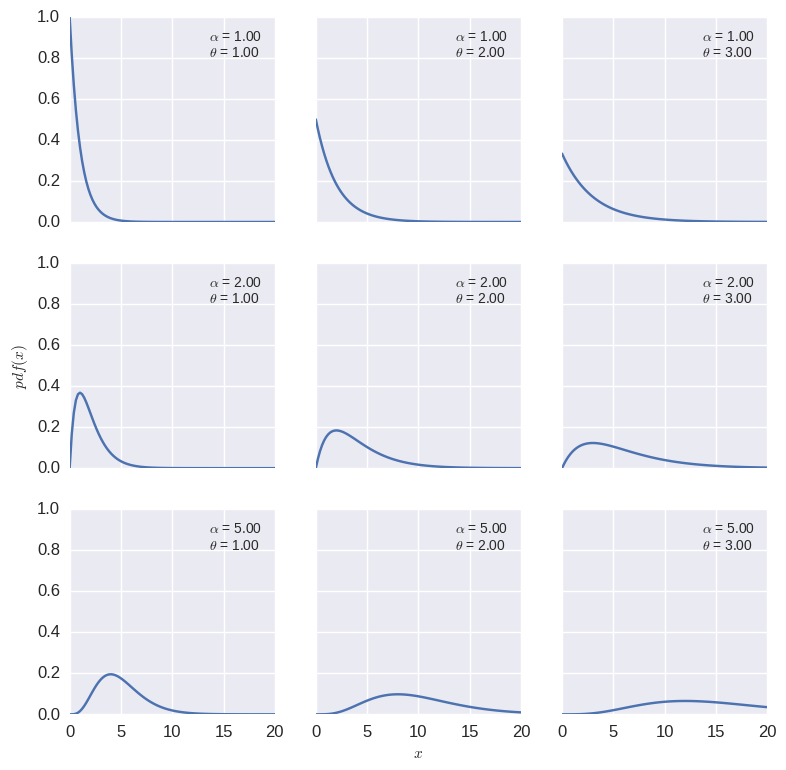

In [6]:
rates = [1, 2, 5]
scales = [1, 2, 3]

x = np.linspace(0, 20, 100)
f, ax = pl.subplots(len(rates), len(scales), sharex=True, sharey=True, figsize=(9, 9))
for i in range(len(rates)):
    for j in range(len(scales)):
        rate = rates[i]
        scale = scales[j]
        rv = stats.gamma(a=rate, scale=scale)
        ax[i,j].plot(x, rv.pdf(x))
        ax[i,j].plot(0, 0, 
        label="$\\alpha$ = {:3.2f}\n$\\theta$ = {:3.2f}".format(rate, scale), alpha=0)
        ax[i,j].legend()
ax[2,1].set_xlabel('$x$')
ax[1,0].set_ylabel('$pdf(x)$');

Creating some synthetic data

/home/madhatter106/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


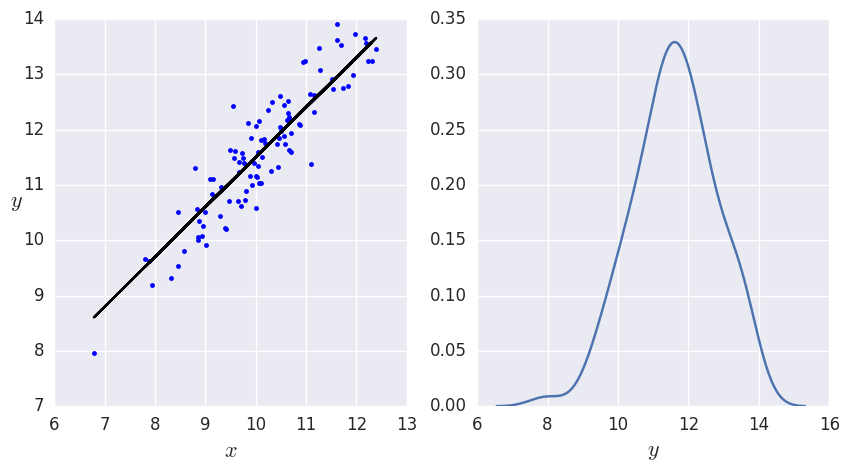

In [108]:
np.random.seed(314)
N = 100
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alfa_real + beta_real * x 
y = y_real + eps_real

pl.figure(figsize=(10,5))
pl.subplot(1,2,1)
pl.plot(x, y, 'b.')
pl.xlabel('$x$', fontsize=16)
pl.ylabel('$y$', fontsize=16, rotation=0)
pl.plot(x, y_real, 'k')
pl.subplot(1,2,2)
sb.kdeplot(y)
pl.xlabel('$y$', fontsize=16)

In [64]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    mu = pm.Deterministic('mu', alpha + beta * x)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    # alternative for the last two lines above:
    #y_pred = pm.Normal('y_pred', mu=alpha + beta * x, sd=epsilon,
                    #   observed=y)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(1e4, step,start)

Optimization terminated successfully.
         Current function value: 72.345620
         Iterations: 13
         Function evaluations: 23
         Gradient evaluations: 23


100%|██████████| 10000/10000.0 [00:02<00:00, 3586.66it/s]


(7, 15)

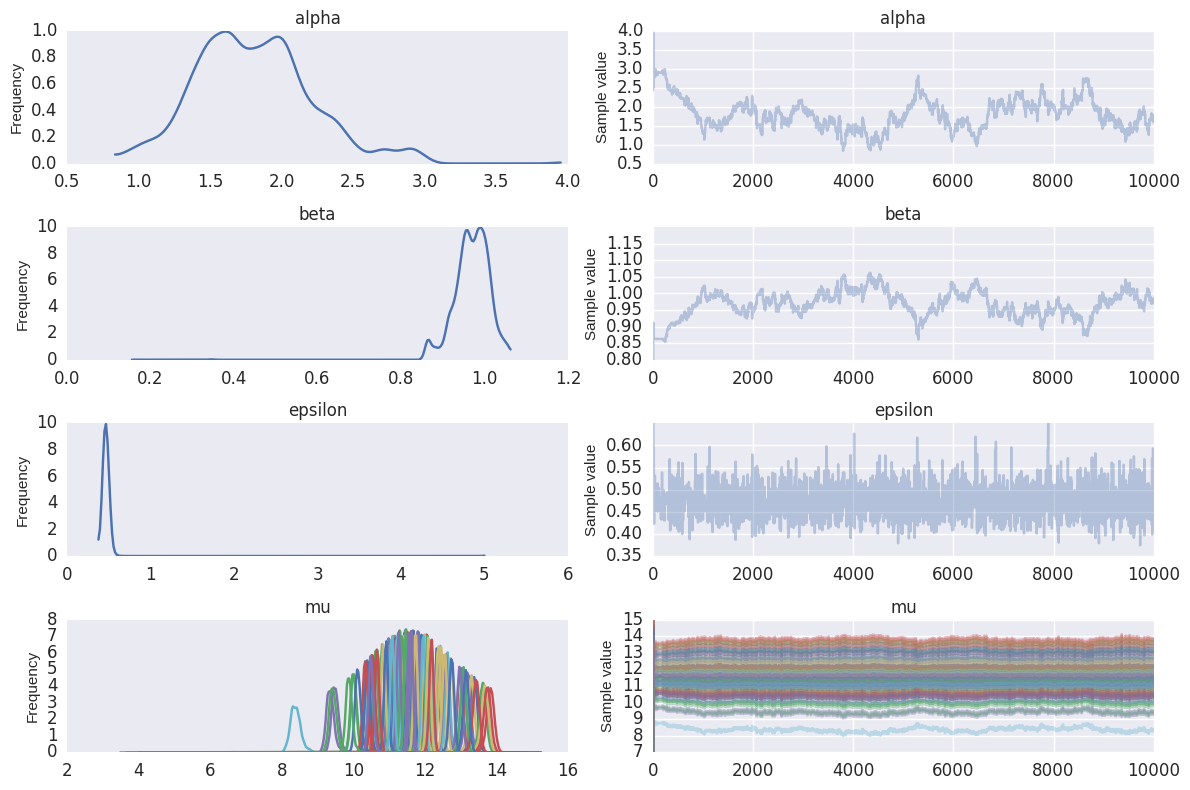

In [75]:
axs = pm.traceplot(trace)
axs[1,1].set_ylim((0.8, 1.2))
axs[2,1].set_ylim((0.35, 0.65));
axs[3,1].set_ylim((7, 15));

This looks weird. Let's look at the autocorrelation plots

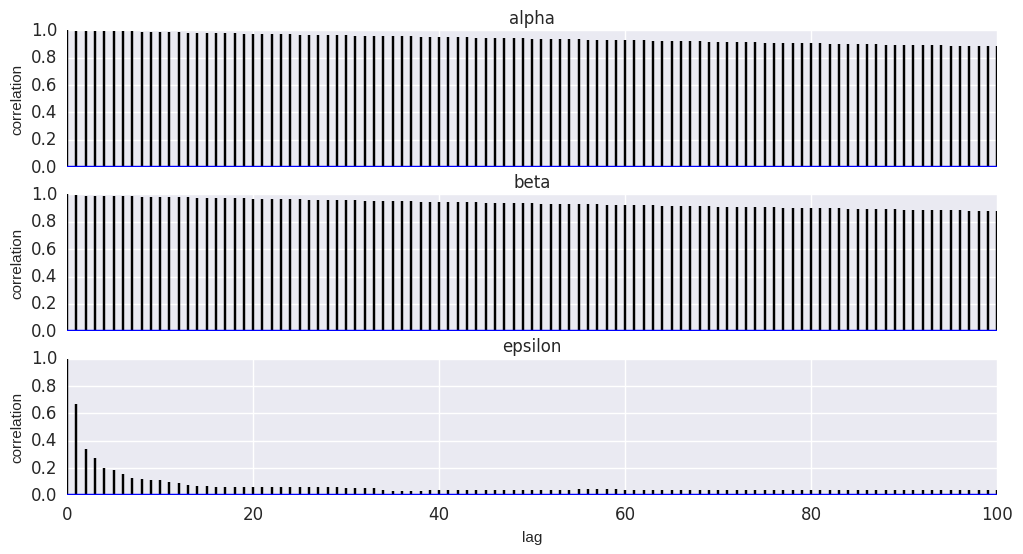

In [33]:
varnames = ['alpha', 'beta', 'epsilon']
pm.autocorrplot(trace, varnames);

Ugly autocorrelation for $\alpha$ and $\beta$. What's up?
Well, we are the victims of our own assumptions. No matter which line we fit to our data, all of them should pass for one point, the mean of the Linear models and high autocorrelation variable and the mean of the Linear models and high autocorrelation variable. Hence the line-fitting process is somehow equivalent to spinning a straight line fixed at the center of the data. An increase in the slope means a decrease of the intercept and the other way around. Both parameters are going to be correlated by the definition of the model. This can be clearly seen if we plot the posterior (we are excluding Linear models and high autocorrelation for clarity):

(0.9, 1.1)

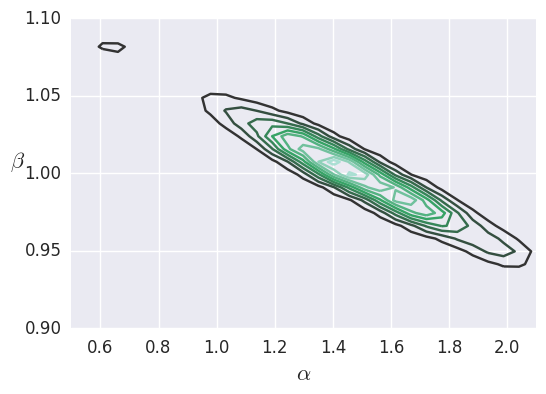

In [42]:
sb.kdeplot(trace['alpha'], trace['beta'])
pl.xlabel(r'$\alpha$', fontsize=16)
pl.ylabel(r'$\beta$', fontsize=16, rotation=0);
pl.xlim((0.5,2.1))
pl.ylim((0.9,1.1))

Hence, the shape of the posterior (excluding Linear models and high autocorrelation) is a very diagonal space. For algorithms such as Metropolis-Hastings, this can be very problematic. Because, if we propose large steps for individual parameters, most of the proposed values will fall outside of this high probability zone; if we propose small steps, they will need to be very really small to accept them. Either way we get a high autocorrelation in the sampling process and a very poor mixing. Even more, the higher the dimensionality of our data the more stressed this problem, because the total parameter space grows much faster than the plausible parameter space; *cf. curse of dimensionality*

Two ways to deal with the problem:
1. **Center the x data at 0 by subtracting the mean**:
    * $x' = x - \bar{x}$ 
    * This has a number of benefits including adjusting the meaning of the y-intercept with a more realistic correspondence to the mean of $\bar{x}$
    * Note that in this case $$\beta' = \beta$$ but $$\alpha=\alpha' - \beta' \bar{x}$$
    * An alternative is to standardize both x and y, e.g. using scikit-learn's standardizer.
2. **Changing sampling method, e.g. using NUTS instead of Metropolis**:

In [43]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [45]:
x_std = sc.fit_transform(x.reshape(-1,1))
y_std = sc.fit_transform(y.reshape(-1,1))

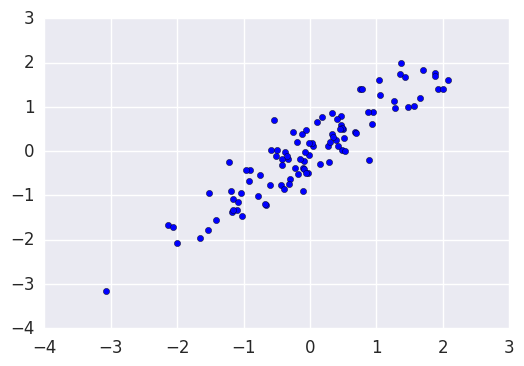

In [50]:
pl.scatter(x_std, y_std)

Note how standardization introduces oft-missing meaning to y-intercept: it's the y-value corresponding to  $\bar{x}$

In [86]:
with pm.Model() as model_std:
    alpha_std = pm.Normal('alpha_std', mu=0, sd=10)
    beta_std = pm.Normal('beta_std', mu=0, sd=1)
    epsilon_std = pm.HalfCauchy('epsilon_std', 5)
    mu_std = pm.Deterministic('mu_std', alpha_std + beta_std * x_std)
    y_pred = pm.Normal('y_pred_std', mu=mu_std, sd=epsilon_std,
                       observed=y_std)
    # alternative for the last two lines above:
    #y_pred = pm.Normal('y_pred', mu=alpha + beta * x, sd=epsilon,
                    #   observed=y)
    start_std = pm.find_MAP()
    step_std = pm.Metropolis()
    trace_std = pm.sample(1e4, step_std, start_std)

Optimization terminated successfully.
         Current function value: 57.799481
         Iterations: 12
         Function evaluations: 22
         Gradient evaluations: 22


100%|██████████| 10000/10000.0 [00:02<00:00, 3506.13it/s]


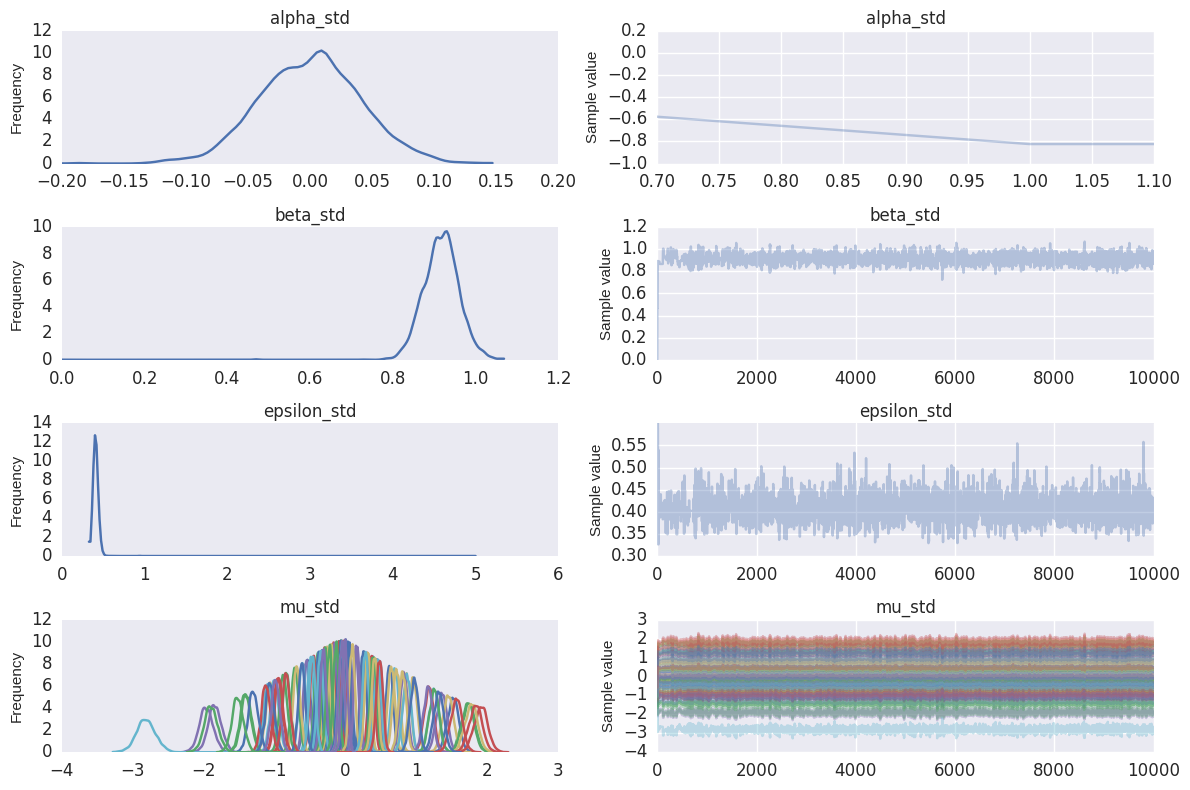

In [93]:
axs_std = pm.traceplot(trace_std);
axs_std[0, 0].set_xlim((-0.2, 0.2))
axs_std[0, 1].set_xlim((0.7, 1.1))
axs
axs_std[2, 1].set_ylim((0.3, 0.6));

This appears to have solved the problem. Let's look at what happens when we use the NUTS sampler

In [132]:
with pm.Model() as model_nuts:
    alpha_nuts = pm.Normal('alpha_nuts', mu=0, sd=10)
    beta_nuts = pm.Normal('beta_nuts', mu=0, sd=1)
    epsilon_nuts = pm.HalfCauchy('epsilon_nuts', 5)
    mu_nuts = pm.Deterministic('mu_nuts', alpha_nuts + beta_nuts * x)
    y_pred_nuts = pm.Normal('y_pred_nuts', mu=mu_nuts, sd=epsilon_nuts,
                            observed=y)
    start_nuts = pm.find_MAP()
    trace_nuts = pm.sample(1e4, start=start_nuts)

Optimization terminated successfully.
         Current function value: 72.345620
         Iterations: 13
         Function evaluations: 23
         Gradient evaluations: 23


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -80.742: 100%|██████████| 200000/200000 [00:20<00:00, 9666.42it/s]
Finished [100%]: Average ELBO = -80.752
100%|██████████| 10000/10000.0 [00:32<00:00, 307.75it/s]


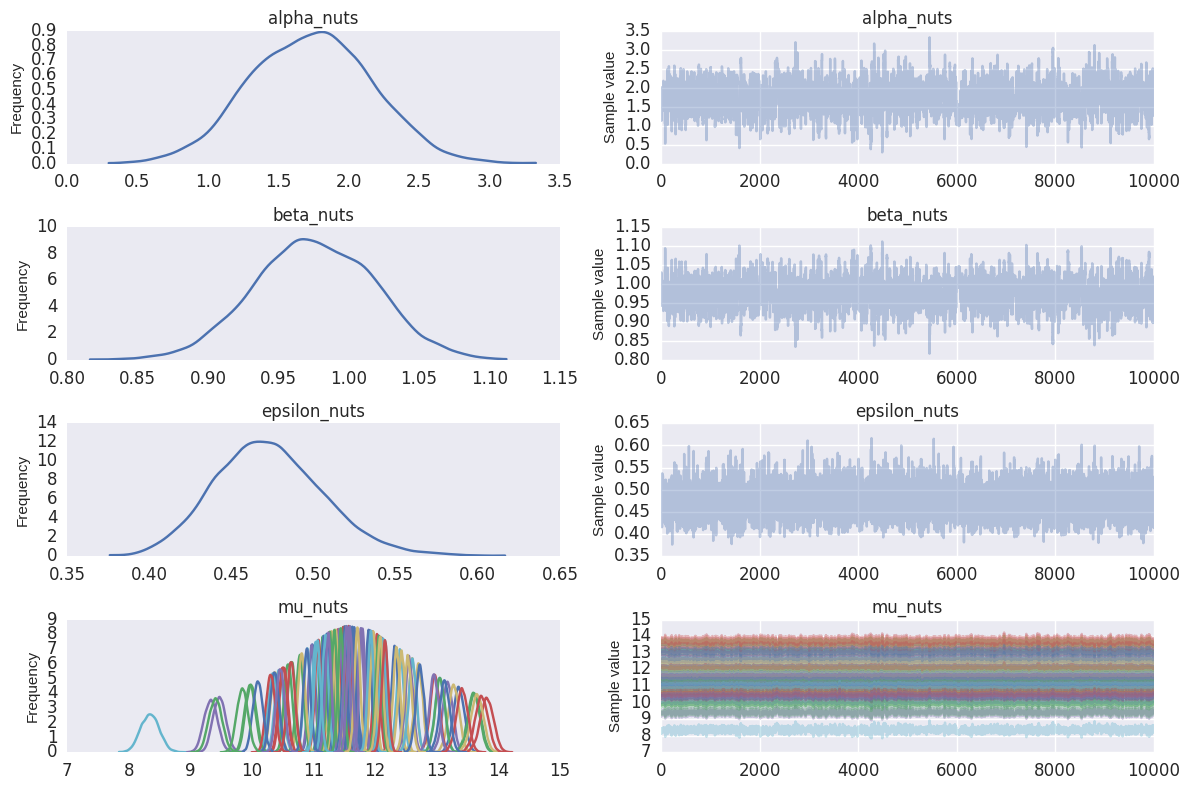

In [90]:
axs = pm.traceplot(trace_nuts)

The problem is also solved when using NUTS.

##### Interpreting the result and visualizing the posteriors (for the NUTS run)
For comparison, I'll add the least-squares version, which is the default linear regressor in the scikit-learn module.

In [106]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x.reshape(-1,1),y)
beta_lsq = lr.coef_
alpha_lsq = lr.intercept_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [119]:
beta_lsq, alpha_lsq

(array([ 0.97362336]), 1.7421096002258274)

For comparison I'll plot the bayesian regression ($y_{bayes}$) to its least squares regression counterpart ($y_{lsq}$). I'll also plot the 95% hdi.

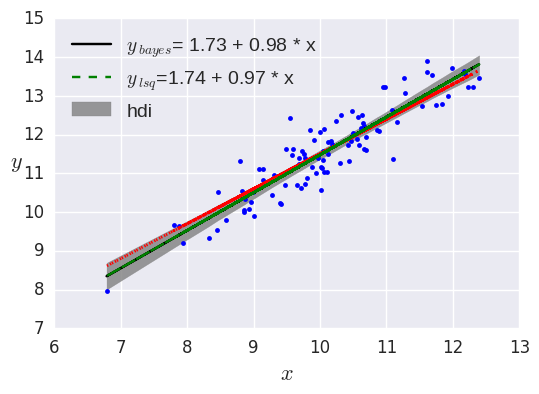

In [131]:
pl.plot(x, y, 'b.');
alpha_m = trace_nuts['alpha_nuts'].mean()
beta_m = trace_nuts['beta_nuts'].mean()
pl.plot(x, alpha_m + beta_m * x, c='k',
        label = r'$y_{\:bayes}$= %.2f + %.2f * x' % (alpha_m, beta_m))
pl.plot(x, y_real, ls =':', c='r', lw=2)
pl.plot(x, alpha_lsq + beta_lsq * x, c='g', ls = '--',
        label='$y_{\:lsq}$=%.2f + %.2f * x' %(alpha_lsq, beta_lsq))
idx_x = np.argsort(x)
x_ord = x[idx_x]
sig = pm.hpd(trace_nuts['mu_nuts'], alpha=0.02)[idx_x]
pl.fill_between(x_ord, sig[:,0], sig[:,1], color='gray',
                label = 'hdi', alpha=0.8)
pl.xlabel('$x$', fontsize=16)
pl.ylabel('$y$', fontsize=16, rotation=0)
pl.legend(loc=2, fontsize=14);

Alternatively hdi can be plotted from predicted (future) data

In [133]:
ppc = pm.sample_ppc(trace_nuts, samples=1000, model=model_nuts)

100%|██████████| 1000/1000 [00:15<00:00, 66.62it/s]


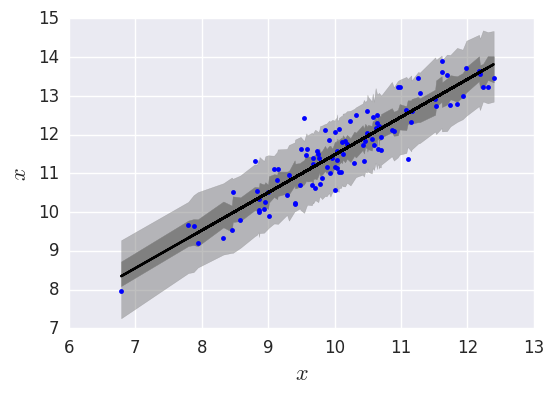

In [139]:
pl.plot(x, y, 'b.')
pl.plot(x, alpha_m + beta_m * x, c='k',
        label = r'$y_{\:bayes}$= %.2f + %.2f * x' % (alpha_m, beta_m))
sig0 = pm.hpd(ppc['y_pred_nuts'], alpha= 0.5)[idx_x] # 50%
sig1 = pm.hpd(ppc['y_pred_nuts'], )[idx_x] # 95%
pl.fill_between(x_ord, sig0[:,0], sig0[:,1], color='gray')
pl.fill_between(x_ord, sig1[:,0], sig1[:,1], color='gray', alpha=0.5)
pl.xlabel('$x$', fontsize=16)
pl.ylabel('$x$', fontsize=16);

"The irregular look of the boundaries of the HPD comes from the fact that, to make this plot, we are taking posterior predictive samples from the observed values of Interpreting and visualizing the posterior and not from a continuous interval, and also from the fact that fill_between is just doing a simple linear interpolation between successive points. Notice how the plot is more serrated the more data points we have. The serrated aspect can be minimized by taking more samples from y_pred."

***

## Robust bayesian linear regression:

 ### How to try a different distribution to adress outliers: 


In [141]:
allData = sb.load_dataset('anscombe')

In [144]:
x_3 = allData[allData.dataset=='III']['x'].values
y_3 = allData[allData.dataset=='III']['y'].values

In [147]:
y_3.shape

(11,)

In [149]:
beta_c, alpha_c, r_val_c, p_val_c = stats.linregress(x_3, y_3)[:4]

/home/madhatter106/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


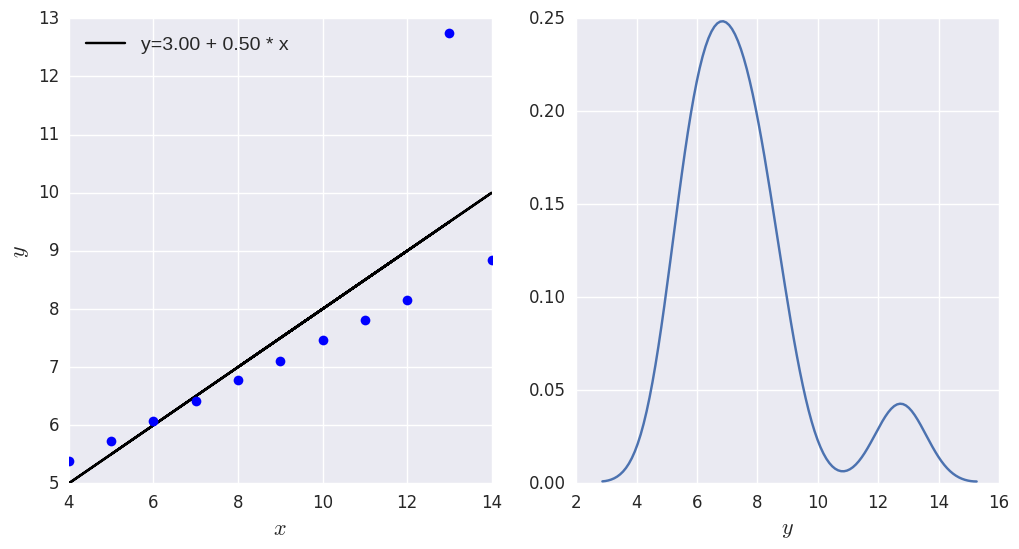

In [152]:
f, axs = pl.subplots(ncols=2, figsize=(12,6))
axs[0].plot(x_3, (alpha_c + beta_c * x_3), 'k',
           label='y=%.2f + %.2f * x' %(alpha_c, beta_c))
axs[0].plot(x_3,y_3, 'bo')
axs[0].set_xlabel('$x$', fontsize=16)
axs[0].set_ylabel('$y$', fontsize=16)
axs[0].legend(loc=0, fontsize=14)
sb.kdeplot(y_3, ax=axs[1])
axs[1].set_xlabel('$y$', fontsize=16)